## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 1000)

import requests
import pandas as pd
from bs4 import BeautifulSoup

from team_map import team_map

## Pull play by play data from nflscrapR

In [2]:
seasons = [2015, 2016, 2017, 2018, 2019]
weeks = [str(w) for w in range(1, 18)]
pbp_url = 'https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/play_by_play_data/regular_season/reg_pbp_'
weather_url = 'http://www.nflweather.com/en/week/'

def pull_pbp_data(seasons, weeks):
    pbp_lst = []
#    pbp_url = 'https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/play_by_play_data/regular_season/reg_pbp_'
    for season in seasons:
        print(f'Reading in Play-By-Play data for the {season} season')
        season_pbp = pd.read_csv(pbp_url + str(season) + '.csv')
        pbp_lst.append(season_pbp)

    pbp_df = pd.concat(pbp_lst).reset_index(drop=True)
    
    pbp_df['game_date'] = pd.to_datetime(pbp_df['game_date'])
    pbp_df['month'] = pbp_df.game_date.dt.month
    pbp_df['year'] = pbp_df.game_date.dt.year
    
    return pbp_df

#Pull Play-By-Play Data NFL scrapR github
pbp_df = pull_pbp_data(seasons, weeks)

Reading in Play-By-Play data for the 2015 season
Reading in Play-By-Play data for the 2016 season
Reading in Play-By-Play data for the 2017 season
Reading in Play-By-Play data for the 2018 season
Reading in Play-By-Play data for the 2019 season


## Define a Player Class
    return play-by-play and relevant information for a player

In [65]:
class Player:
    
    def __init__(self, number, position, team, name, player_id):
        self.number = number
        self.position = position
        self.team = team
        self.name = name
        self.player_id = player_id
        
    def get_player_pbp_data(self, pbp_df):
        pos_col = self.position + '_player_id'
        player_pbp_df = pbp_df.loc[pbp_df[pos_col] == self.player_id].reset_index(drop=True)
        
        return player_pbp_df
    
    def get_agg_stats(self, player_pbp_df, agg_lst, stat_lst):
        
        agg_stats_df = player_pbp_df.groupby(agg_lst, as_index=False)[stat_lst].sum()
        
        agg_stats_df['amari_home'] = np.where((agg_stats_df['home_team'] == 'OAK') |
                                              (agg_stats_df['home_team'] == 'DAL'),
                                              'Y', 'N')
        
        agg_stats_df['team'] = np.where(agg_stats_df['amari_home'] == 'Y', 
                                        agg_stats_df['home_team'],
                                        agg_stats_df['away_team'])
        
        return agg_stats_df
    

Instantiate the class for Amari

In [72]:
amari = Player(80, 'receiver', 'Cowboys', 'A.Cooper', '00-0031544')
amari_pbp = amari.get_player_pbp_data(pbp_df)
#Filter out Jan games
amari_pbp = amari_pbp.loc[amari_pbp.month >= 9]
agg_lst = ['game_id','year','month','home_team','away_team','qtr']
stat_lst = ['yards_gained', 'epa']
amari_stats_per_game_qtr = amari.get_agg_stats(amari_pbp, agg_lst, stat_lst)


amari_stats_per_game = amari_stats_per_game_qtr.groupby([c for c in agg_lst if c != 'qtr']
                                                        + ['amari_home', 'team'], as_index=False)['epa'].sum()

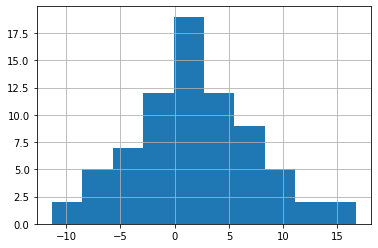

In [74]:
amari_stats_per_game.epa.hist()

## Exploring the data

#### EPA per Game by Month, broken down by Team

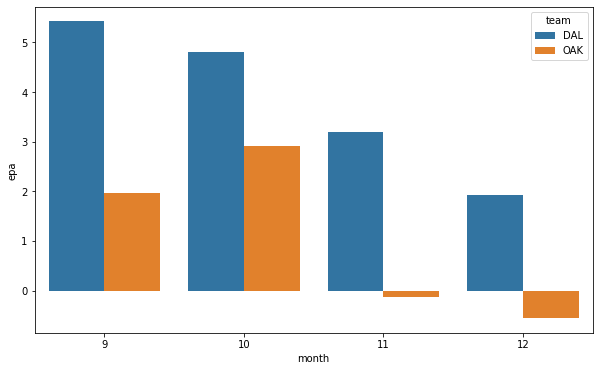

In [75]:
monthly_team_epa_per_game = amari_stats_per_game.groupby(['month', 'team'], as_index=False)['epa'].mean()

plt.figure(figsize=(10,6))
sns.barplot(x= 'month', y = 'epa', data=monthly_team_epa_per_game, hue='team')

#### Home vs Road EPA per game

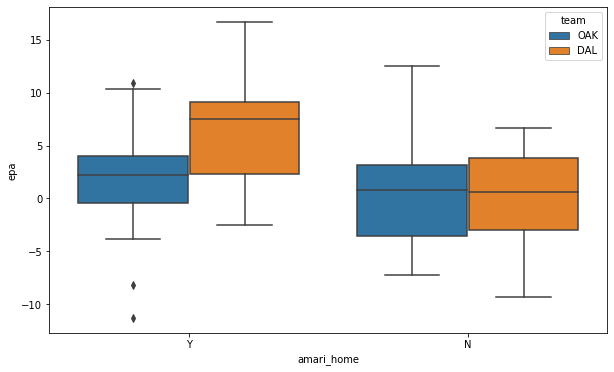

In [76]:
plt.figure(figsize=(10,6))
sns.boxplot(x= 'amari_home', y = 'epa', data=amari_stats_per_game, hue='team')

#### Avg EPA per Quarter

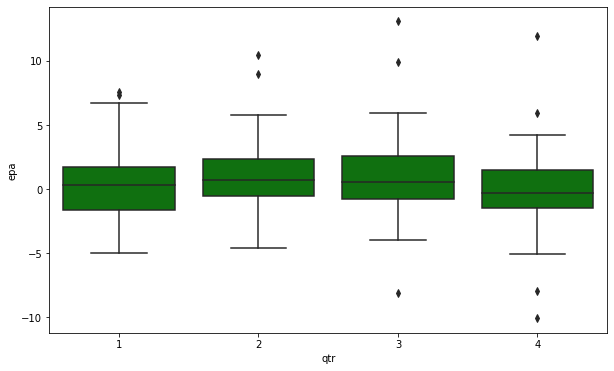

In [93]:
#filter out overtime
amari_stats_per_game_qtr = amari_stats_per_game_qtr.loc[amari_stats_per_game_qtr.qtr < 5]

plt.figure(figsize=(10,6))
sns.boxplot(x='qtr', y='epa', data=amari_stats_per_game_qtr, color = 'green')

#### EPA per Quarter & Home v Road

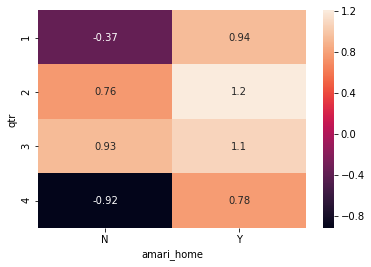

In [95]:
sns.heatmap(amari_stats_per_game_qtr.groupby(['qtr', 'amari_home'], as_index=False)['epa'].mean() \
    .pivot('qtr', 'amari_home', 'epa'), annot = True)

#### vs Top Corners

`https://bleacherreport.com/articles/2782436-ranking-the-nfls-best-shutdown-cornerbacks`

Amari has played against 8 of the 10 corners on the list

In [178]:
corner_lst = ['M.Peters','A.Bouye','C.Hayward','M.Lattimore','D.Slay','A.Talib','T.White','M.Peters']

corner_game_ids = amari_pbp.loc[amari_pbp.pass_defense_1_player_name.isin(corner_lst), 'game_id'].unique()

amari_stats_per_game['top_corner'] = np.where(amari_stats_per_game['game_id'].isin(corner_game_ids), 'Y', 'N')

amari_stats_per_game.groupby(['top_corner'], as_index=False)['epa'].mean()

,top_corner,epa
0,N,2.301360
1,Y,-0.738198


## Scrape Weather Data

In [96]:
def request_data(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    
    return soup

def get_team_data(bs_data):
    teams = bs_data.find_all(class_="team-name text-center")

    away_teams = []
    home_teams = []

    for i, v in enumerate(teams):
        if i % 2 == 0:
            away_teams.append(teams[i].find('a').contents[0])
        else:
            home_teams.append(teams[i].find('a').contents[0])
            
    return away_teams, home_teams

def get_weather_data(bs_data):
    games = bs_data.find_all('tr')

    weather_lst = []
    for i, v in enumerate(games):
        #skip header
        if i > 0:
            game_details = games[i].find_all(class_='text-center')

            forecast = game_details[5].contents[0]

            weather_lst.append(' '.join(forecast.split()))
            
    return weather_lst

weather_lst = []

for season in seasons:
    print(f'Scraping Weather Data for the {season} Season')
    for week in weeks:
        request_url = f'{weather_url}{season}/week-{week}'
        soup = request_data(request_url)
        
        away_teams, home_teams = get_team_data(soup)
        
        weather = get_weather_data(soup)
        
        weather_df = pd.DataFrame({'away_tm': away_teams,
                                   'home_tm': home_teams,
                                   'weather': weather,
                                  })
        
        weather_df['year'] = season
        weather_df['week'] = week
        
        weather_lst.append(weather_df)
        
full_weather_df = pd.concat(weather_lst).reset_index(drop=True)

coop_weather_df = full_weather_df.loc[(full_weather_df.away_tm.isin(['Cowboys','Raiders'])) |
                                      (full_weather_df.home_tm.isin(['Cowboys','Raiders']))]

amari_pbp = amari_pbp.replace('SD', 'LAC')

coop_weather_df['away_team'] = coop_weather_df['away_tm'].apply(lambda x: team_map[x])
coop_weather_df['home_team'] = coop_weather_df['home_tm'].apply(lambda x: team_map[x])

merged_coop_df = amari_pbp.merge(coop_weather_df, how = 'left', on = ['away_team', 'home_team', 'year'])

merged_coop_df['temp'] = np.where(merged_coop_df.weather == 'DOME',
                                  -999,
                                  merged_coop_df.weather.str.split('f').str[0]).astype(int)

Scraping Weather Data for the 2015 Season
Scraping Weather Data for the 2016 Season
Scraping Weather Data for the 2017 Season
Scraping Weather Data for the 2018 Season
Scraping Weather Data for the 2019 Season


## Explore Performance by Game Temperature

In [97]:
merged_coop_df['temp_bin'] = np.where(merged_coop_df.temp < 50, "<50",
                                      np.where(merged_coop_df.temp < 75,'50-75',
                                      np.where(merged_coop_df.temp >= 75, '>=75', 'NO TEMP')))

temp_bin_df = merged_coop_df.groupby(['temp_bin'], as_index = False)['game_id',] \
    .agg(pd.Series.nunique) \
    .merge(merged_coop_df.groupby(['temp_bin'], as_index = False)['yards_gained',]
           .agg(np.sum), on = 'temp_bin')

temp_bin_df['yards_per_game'] = temp_bin_df['yards_gained'] / temp_bin_df['game_id']

temp_bin_df.columns = ['temperature', 'games', 'total_yards', 'yards_per_game']

temp_bin_df.yards_per_game = temp_bin_df.yards_per_game.round(1)

temp_bin_df['total_yards'] = temp_bin_df.apply(lambda x: "{:,}".format(x['total_yards']), axis=1)
temp_bin_df.sort_values('yards_per_game')

,temperature,games,total_yards,yards_per_game
1,<50,21,"1,047",49.9
0,50-75,35,"2,280",65.1
2,>=75,19,"1,713",90.2
